In [67]:
import pandas as pd
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.svm import LinearSVC,LinearSVR
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix,classification_report
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import time
import coremltools
import matplotlib.pyplot as plt

In [68]:
#load the data file 
data=pd.read_csv('preprocessed.csv')
data.head()
#separate into features and target variable
features=data.drop(['disease','Unnamed: 0'],1)
target=data['disease']
target=target.astype('int64')

In [70]:
#prepprocess the features
#convert the categorical variables to dummy variables by encoding each category with a unique number
#here the chest pain feature has 4 categories which are assigned a number from 0 to 3

def preprocess_features_xgb(features,unique_cp,unique_re):
    for v in unique_cp:
        features.replace(v,unique_cp.index(v),inplace=True)

    for v in unique_re:
        features.replace(v,unique_re.index(v),inplace=True)

    features=features.astype('int64')
    return features

unique_cp=list(features['chest_pain'].unique())
unique_re=list(features['rest_electro'].unique())
features=preprocess_features_xgb(features,unique_cp,unique_re)


In [71]:
#SMOTE an algorith used for oversampling. It generates a dataset that has equal proportions of data samples for positive and negative classes
#create new random samples from the minor class for equal distribution
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
x_train,x_test,y_train,y_test=train_test_split(features,target,test_size=0.2, random_state=0)

columns = x_train.columns
os_data_x , os_data_y=os.fit_sample(x_train, y_train)
os_data_x = pd.DataFrame(data=os_data_x , columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['disease'])
os_data_x=os_data_x.astype('int64')
os_data_y=os_data_y.astype('int64')
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_x))

print('no of positives in over sampled data:', len(os_data_y[os_data_y['disease']==1]))
print('no of positives in over sampled data:', len(os_data_y[os_data_y['disease']==0]))

length of oversampled data is  188
no of positives in over sampled data: 94
no of positives in over sampled data: 94


In [72]:
#trains the model and generats a report for the performance metrics 
def train(model,model_name,x_train,y_train,x_test,y_test):    
    print(model_name)
    print(' ')
    print("training dataset size",len(x_train))
    start=time.time()
    model.fit(x_train,y_train)
    end=time.time()
    y_pred=model.predict(x_train)
    acc_train=model.score(x_train,y_train)
    y_pred=model.predict(x_test)
    acc_test=model.score(x_test,y_test)

    
    print('time for training: ',end-start)
    print('Accuracy of model on train dataset:  {:.2f} %'.format(acc_train*100))
    print('Accuracy of model on test dataset:  {:.2f} %'.format(acc_test*100))
    
    print('CONFUSION MATRIX:')
    print(confusion_matrix(y_test,y_pred))
    print('RESULTS')
    report=classification_report(y_pred,y_test)
    print(report)
    

In [73]:

model=xgb.XGBClassifier()
train(model,'XGB',x_train,y_train,x_test,y_test)
#save coreml model
coreml_model = coremltools.converters.xgboost.convert(model._Booster)
coreml_model.save('xgb.mlmodel')


XGB
 
training dataset size 161
time for training:  0.063507080078125
Accuracy of model on train dataset:  96.89 %
Accuracy of model on test dataset:  75.61 %
CONFUSION MATRIX:
[[14  4]
 [ 6 17]]
RESULTS
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        20
           1       0.74      0.81      0.77        21

   micro avg       0.76      0.76      0.76        41
   macro avg       0.76      0.75      0.75        41
weighted avg       0.76      0.76      0.76        41



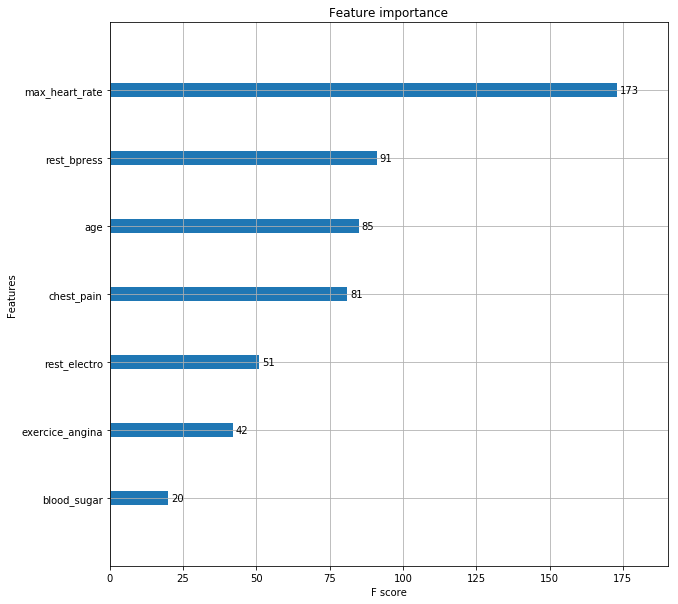

<Figure size 720x720 with 0 Axes>

In [74]:
#plot the importance of each feature in tree generation
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()
plt.savefig('feature_importance.png')

In [75]:
#geneate predictions for a new record given as input
def predict_label_xgb(model,d):
    if d['blood_sugar']=='t':
        d['blood_sugar']=1
    else:
        d['blood_sugar']=0

    if d['exercice_angina']=='yes':
        d['exercice_angina']=1
    else:
        d['exercice_angina']=0
    d['chest_pain']=unique_cp.index(d['chest_pain'])
    d['rest_electro']=unique_re.index(d['rest_electro'])
    temp=pd.DataFrame(columns=d.keys())
    for key,value in d.items():
        temp.loc[0,key]=value
    #print (temp)
    result=model.predict(temp)
    prob=model.predict_proba(temp)
    if result==0:
        print ('Negative with probability',prob[0][0])
    else:
        print('Positive with probability',prob[0][1])
    

In [76]:
    
sample=d={'age':29,'chest_pain':'non_anginal','rest_bpress':120,'blood_sugar':'t','rest_electro':'normal','max_heart_rate':120,'exercice_angina':'yes'}
predict_label(model,sample)

Negative with probability 0.612113
